## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras
import itertools

# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICE"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4, l2_ratio=1e-4):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units,
                                   activation="relu",
                                   name=f"hidden_layer{i+1}",
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units,
                                   activation="relu",
                                   name=f"hidden_layer{i+1}",
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
            
        out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
        
        model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 30
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-6, 0.0]
L2_EXP = [1e-2, 1e-4]

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

for l1, l2 in itertools.product(L1_EXP, L2_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print(f"Experiment with L1 = {l1:.7f} and L2 = {l2:.5f}")
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=l1, l2_ratio=l2)
    model.summary()
    
    opt = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=opt)
    
    model.fit(x_train, 
              y_train,
              epochs=EPOCHS,
              validation_data=(x_test, y_test),
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = f"exp-L1:{l1}, L2:{l2}"
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

W0718 00:25:35.567861 17988 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0718 00:25:35.568861 17988 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0718 00:25:35.585868 17988 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0718 00:25:35.586871 17988 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0718 00:25:35.588852 17988 depr

Experiment with L1 = 0.0100000 and L2 = 0.01000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


W0718 00:25:35.934016 17988 deprecation.py:323] From C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 11s 224us/step - loss: 28.6659 - acc: 0.1147 - val_loss: 2.4627 - val_acc: 0.1000
Epoch 2/30
50000/50000 [==============================] - 9s 190us/step - loss: 2.4624 - acc: 0.0976 - val_loss: 2.4620 - val_acc: 0.1000
Epoch 3/30
50000/50000 [==============================] - 10s 190us/step - loss: 2.4621 - acc: 0.1004 - val_loss: 2.4620 - val_acc: 0.1000
Epoch 4/30
50000/50000 [==============================] - 9s 189us/step - loss: 2.4621 - acc: 0.0979 - val_loss: 2.4617 - val_acc: 0.1000
Epoch 5/30
50000/50000 [==============================] - 9s 189us/step - loss: 2.4619 - acc: 0.0967 - val_loss: 2.4616 - val_acc: 0.1000
Epoch 6/30
50000/50000 [==============================] - 9s 189us/step - loss: 2.4617 - acc: 0.0985 - val_loss: 2.4614 - val_acc: 0.1000
Epoch 7/30
50000/50000 [==============================] - 9s 189us/step - loss: 2.4615 - acc: 0.0995 - val_loss: 2.4613

Epoch 22/30
50000/50000 [==============================] - 9s 181us/step - loss: 2.4627 - acc: 0.0980 - val_loss: 2.4627 - val_acc: 0.1000
Epoch 23/30
50000/50000 [==============================] - 9s 181us/step - loss: 2.4627 - acc: 0.0991 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 24/30
50000/50000 [==============================] - 9s 181us/step - loss: 2.4627 - acc: 0.0983 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 25/30
50000/50000 [==============================] - 9s 181us/step - loss: 2.4627 - acc: 0.0967 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 26/30
50000/50000 [==============================] - 9s 182us/step - loss: 2.4627 - acc: 0.0988 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 27/30
50000/50000 [==============================] - 9s 182us/step - loss: 2.4627 - acc: 0.0978 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 28/30
50000/50000 [==============================] - 9s 181us/step - loss: 2.4627 - acc: 0.0987 - val_loss: 2.4627 - val_acc: 0.1000
Epoch 29/30
50000/50000 [==

50000/50000 [==============================] - 10s 192us/step - loss: 3.5215 - acc: 0.4760 - val_loss: 3.3294 - val_acc: 0.4791
Epoch 6/30
50000/50000 [==============================] - 9s 188us/step - loss: 3.1632 - acc: 0.4853 - val_loss: 3.0378 - val_acc: 0.4797
Epoch 7/30
50000/50000 [==============================] - 9s 182us/step - loss: 2.8611 - acc: 0.4923 - val_loss: 2.7500 - val_acc: 0.4926
Epoch 8/30
50000/50000 [==============================] - 9s 178us/step - loss: 2.6125 - acc: 0.4940 - val_loss: 2.5155 - val_acc: 0.4948
Epoch 9/30
50000/50000 [==============================] - 9s 175us/step - loss: 2.4118 - acc: 0.4957 - val_loss: 2.3536 - val_acc: 0.4897
Epoch 10/30
50000/50000 [==============================] - 9s 176us/step - loss: 2.2488 - acc: 0.4981 - val_loss: 2.2520 - val_acc: 0.4715
Epoch 11/30
50000/50000 [==============================] - 9s 174us/step - loss: 2.1248 - acc: 0.4983 - val_loss: 2.1277 - val_acc: 0.4876
Epoch 12/30
50000/50000 [=================

50000/50000 [==============================] - 9s 170us/step - loss: 1.7296 - acc: 0.4513 - val_loss: 1.7697 - val_acc: 0.4364
Epoch 27/30
50000/50000 [==============================] - 9s 173us/step - loss: 1.7264 - acc: 0.4547 - val_loss: 1.6955 - val_acc: 0.4617
Epoch 28/30
50000/50000 [==============================] - 9s 172us/step - loss: 1.7258 - acc: 0.4520 - val_loss: 1.7034 - val_acc: 0.4616
Epoch 29/30
50000/50000 [==============================] - 9s 171us/step - loss: 1.7250 - acc: 0.4529 - val_loss: 1.7209 - val_acc: 0.4480
Epoch 30/30
50000/50000 [==============================] - 9s 170us/step - loss: 1.7284 - acc: 0.4533 - val_loss: 1.7093 - val_acc: 0.4677
Experiment with L1 = 0.0000010 and L2 = 0.00010
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidde

50000/50000 [==============================] - 8s 154us/step - loss: 1.7669 - acc: 0.4396 - val_loss: 1.7753 - val_acc: 0.4364
Epoch 10/30
50000/50000 [==============================] - 8s 155us/step - loss: 1.7612 - acc: 0.4425 - val_loss: 1.7424 - val_acc: 0.4543
Epoch 11/30
50000/50000 [==============================] - 8s 155us/step - loss: 1.7589 - acc: 0.4421 - val_loss: 1.7475 - val_acc: 0.4445
Epoch 12/30
50000/50000 [==============================] - 8s 154us/step - loss: 1.7597 - acc: 0.4424 - val_loss: 1.7512 - val_acc: 0.4476
Epoch 13/30
50000/50000 [==============================] - 8s 156us/step - loss: 1.7525 - acc: 0.4465 - val_loss: 1.7755 - val_acc: 0.4271
Epoch 14/30
50000/50000 [==============================] - 8s 154us/step - loss: 1.7472 - acc: 0.4474 - val_loss: 1.7420 - val_acc: 0.4510
Epoch 15/30
50000/50000 [==============================] - 8s 155us/step - loss: 1.7466 - acc: 0.4471 - val_loss: 1.7479 - val_acc: 0.4412
Epoch 16/30
50000/50000 [==============

50000/50000 [==============================] - 7s 149us/step - loss: 0.9777 - acc: 0.7071 - val_loss: 1.5794 - val_acc: 0.5346


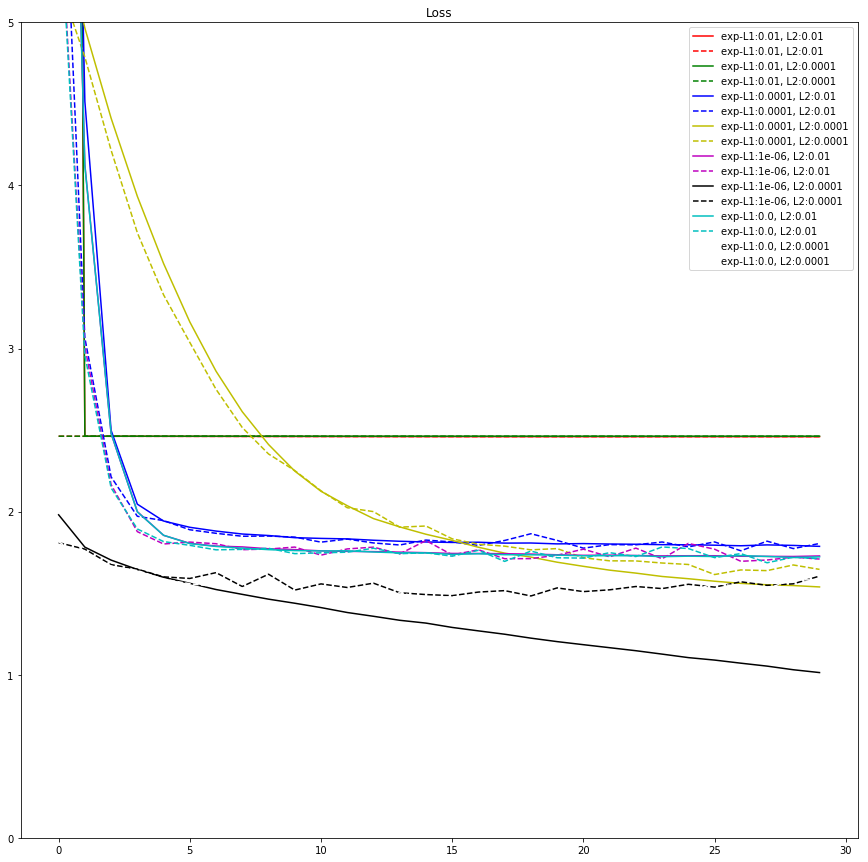

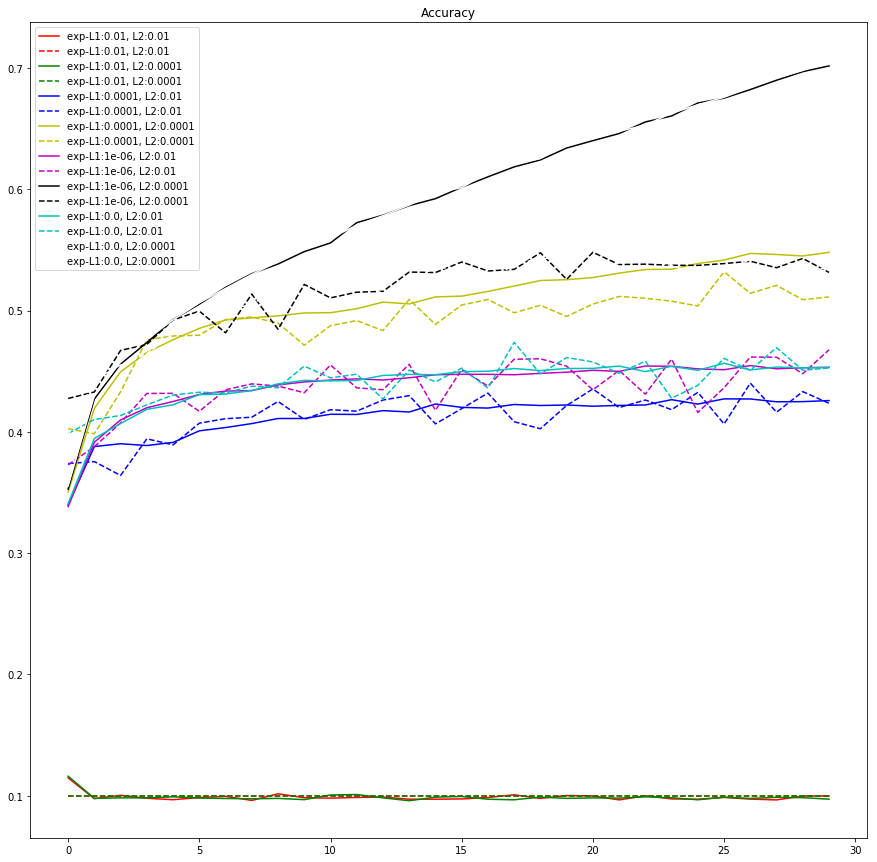

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k", "c", "w"]

plt.figure(figsize=(15, 15))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(15, 15))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()